In [1]:
# Google Colab notebook that can be used to run trials reported on in "RECURSIVE CONSTRUCTION OF STABLE ASSEMBLIES OF RECURRENT NEURAL NETWORKS"
# major user settings are found in the next two cells after this
# desired trial can then be run by simply running all cells
# code expects GPU runtime, efficiency may vary depending on assigned GPU

# existing output seen in later cells is from trial #10 of the CIFAR10 repeatability experiments

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.jit as jit
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset
from torch._utils import _accumulate
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split 
from tqdm.auto import tqdm

import numpy as np
import numpy.random as npr
import scipy.sparse
import scipy.integrate

import pandas as pd
import matplotlib.pyplot as plt
import os

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.9/dist-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
!python -m pip uninstall torch --yes
!pip install torch==1.13.1

Found existing installation: torch 1.13.1
Uninstalling torch-1.13.1:
  Successfully uninstalled torch-1.13.1
  Using cached torch-1.13.1-cp39-cp39-manylinux1_x86_64.whl (887.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu116 requires torch==1.12.0, but you have torch 1.13.1 which is incompatible.
torchaudio 0.12.0+cu116 requires torch==1.12.0, but you have torch 1.13.1 which is incompatible.


In [3]:
# major model settings - by default best performing settings
task = "mnist" # will accept cifar10, pmnist, or mnist
ns = [32 for x in range(16)] # list of integers, with each integer being the size for a component RNN. the number of component RNNs is then the length of the list
rnn_density = 0.033 # density setting for each component RNN
pre_scalar = 30.0 # sample non-zero entries for potential component RNN uniformly from -pre_scalar to pre_scalar, keep only if satisfies theorem 1
# (note that if density and pre_scalar settings are both too large code will stall because it will be impossible to find component RNNs meeting the condition)
post_scalar = 0.2 # multiply chosen component RNNs by post_scalar before beginning training (should be a positive number <= 1)

# training settings - uses Adam optimizer
num_epochs = 200 #updated by Laura to 1 from original of 200 by the research team
lr = 1e-3
lr_scale_epochs = [140, 190] # the epochs after which to perform a learning rate cut
lr_scalar = 0.1 # the scalar to multiply the learning rate by at the specified epochs
weight_decay = 1e-5

# adjacency matrix settings - this is experimental
A_sparsity = 0 # this will be fraction of possible negative feedback connections between component RNNs that are set to 0

#### Personal Note 12/07/22, added by Laura De Los Santos
I updated the number of epochs, this will probably be an issue with the replicability point, but I do not have the capacity to leave it running for that long. 

In [4]:
# settings for saving model stats and checkpoints using a specified Google Drive account
# model checkpoint is saved after each epoch, as well as an updated CSV with per-epoch training loss and test accuracy

#from google.colab import drive
#drive.mount('/content/drive')

# output file path info
output_root = "/notebooks/Modelshare" # folder path everything will be saved to
model_name = "Test" # specific trial name to use as part of each file's save name

In [5]:
# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print('Default tensor type is now cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

Default tensor type is now cuda


In [6]:
# functions for initializing the sparse matrices

# function that checks the Theorem 1 condition for an input square matrix
def check_cond(W):
    W_diag_only = np.diag(np.diag(W))
    W_diag_pos_only = W_diag_only.copy()
    W_diag_pos_only[W_diag_pos_only < 0] = 0.0
    W_abs_cond = np.abs(W - W_diag_only) + W_diag_pos_only
    max_eig_abs_cond = np.max(np.real(np.linalg.eigvals(W_abs_cond)))
    if max_eig_abs_cond < 1:
        return True
    else:
        return False

# sampling function to use for each non-zero element in a generated matrix
# (uniform but between -1 and 1 instead of default 0 to 1)
def uniform_with_neg(x):
    return np.random.uniform(low=-1.0,high=1.0, size=x)

# function that creates a square matrix of a given size with a given density and distribution (+ scalar for the distribution)
# also zeroes out the diagonal after generation
# the uniform_with_neg function is used as the sampling function by default
def generate_random_sparse_matrix(num_units, density, dist_multiplier, dist_func=uniform_with_neg):
    test = scipy.sparse.random(num_units,num_units,density=density,format='csr',data_rvs=dist_func)
    np_test = test.toarray()
    np_test = dist_multiplier * np_test
    np.fill_diagonal(np_test, 0)
    return np_test

# create a full set of RNN modules using the above functions
# will only keep a given random RNN if it meets the condition for theorem 1
def create_modules(module_sizes, density, dist_multiplier, post_select_multiplier):
    modules = []
    for m in module_sizes:
        okay = False
        while not okay:
            cur_matrix = generate_random_sparse_matrix(m, density, dist_multiplier)
            okay = check_cond(cur_matrix)
        cur_matrix = post_select_multiplier * cur_matrix # once reach here the current matrix is one of the ones selected
        modules.append(cur_matrix)
    return modules

# function to put together the generated component RNNs into one big block diagonal weight matrix
def combine_W(W_list):
    shapes = [w.shape[0] for w in W_list]
    total_size = np.sum(shapes)
    full_W = np.zeros((total_size, total_size))
    for i in range(len(W_list)):
        cur_W = W_list[i]
        cur_size = shapes[i]
        first_index = int(np.sum(shapes[0:i]))
        last_index = first_index + cur_size
        full_W[first_index:last_index, first_index:last_index] = cur_W
    return full_W

# use theorem 1 + info about linear stability to find a metric for a given weight matrix (expected to be generated from the above)
def find_M(W_inp):
    # what we actually want to find metric for is W - I -> just W won't be stable here
    # also first need to focus on abs(W), not W itself! that is what linear stable test can find, the same metric will then work for the other (per Thm 1)
    W = np.abs(W_inp) # diagonal is set to 0 already so no need to worry about that
    W = W - np.identity(W.shape[0])
    # this just finds some M that will work, could be many others
    Q = np.identity(W.shape[0])
    # solve for M in -Q = M * W + np.transpose(W) * M
    # using integration formula for LTI system
    P = np.zeros(W.shape)
    for i in range(W.shape[0]):
        # integrating elementwise
        # keep off-diags as 0 to save time with larger martrix, as know there will be some diagonal metric, expect good odds that will find one with Q = I
        # will confirm the metric works before moving forward though (done in final function below), to be sure with stability guarantee
        def func_to_integrate(t):
            og_func = np.exp(np.transpose(W) * t) * Q * np.exp(W * t)
            return og_func[i, i]
        P[i,i] = scipy.integrate.quad(func_to_integrate, 0, np.inf)[0]
    if np.max(np.linalg.eigvals(P)) <= 0:
        # guaranteed M will be symmetric as it is definitely diagonal here, but also need it be PD for it to be a valid metric
        # should never reach this in theory, but add as a check to be safe
        print("returned metric not PD, problem!")
        return None
    return P

# replaced version of this function with more efficient one when I started using this notebook for the final version of the CIFAR10 experiment repetitions
# put everything together to get W and M to perform the training with
# W is of course part of the network
# M is used in finding negative feedback connections between components of W that maintain stability
# neither are themselves updated over the course of training
def generate_initial_W_M(module_sizes, density, dist_multiplier, post_select_multiplier):
    individual_networks = create_modules(module_sizes, density, dist_multiplier, post_select_multiplier)
    full_W = combine_W(individual_networks)

    # in prior experiments 0.5 * I was metric generally found
    # so just use that if it will work - only integrate if necessary
    matching_M = 0.5*np.identity(full_W.shape[0])
    check_formula = matching_M * (np.abs(full_W) - np.identity(full_W.shape[0])) + np.transpose(np.abs(full_W) - np.identity(full_W.shape[0])) * matching_M
    if np.max(np.linalg.eigvals(check_formula)) >= 0:
        matching_M = find_M(full_W)

        # confirm that M does work to satisfy the Theorem 1 condition with this W
        check_formula = matching_M * (np.abs(full_W) - np.identity(full_W.shape[0])) + np.transpose(np.abs(full_W) - np.identity(full_W.shape[0])) * matching_M
        if np.max(np.linalg.eigvals(check_formula)) >= 0:
            print("problem with found metric!")
            return None

    # return the final W and M
    # need these to be tensors for computation to work - but they aren't parameters!
    return torch.from_numpy(full_W).float().cuda(), torch.from_numpy(matching_M).float().cuda()

In [7]:
# helper functions for training

def add_channels(X):
    # reshaping necessary when loading the training data
    if len(X.shape) == 2:
        return X.reshape(X.shape[0], 1, X.shape[1], 1)
    elif len(X.shape) == 3:
        return X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
    else:
        return "dimenional error"
 
def exp_lr_scheduler(epoch,
                     optimizer,
                     strategy='normal',
                     decay_eff=0.1,
                     decayEpoch=[]):
    """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""
 
    if strategy == 'normal':
        if epoch in decayEpoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= decay_eff
            print('New learning rate is: ', param_group['lr'])
    else:
        print('wrong strategy')
        raise ValueError('A very specific bad thing happened.')
 
    return optimizer
 
# get adjacency matrix specifying which modules should be in negative feedback with each other
# for full negative feedback frac_zeros would be 0, but will play with sparsity settings
# (this is part of initialization)
def create_random_A(ns,frac_zeros):
    num_networks = len(ns)
    A = torch.cuda.FloatTensor(num_networks, num_networks).uniform_() > frac_zeros
    A_tril = torch.tril(A)
    A_tril.fill_diagonal_(0)
    # note only lower triangular needs to be trained, as bidirectional version of connection determined by negative feedback stability cond
    return A_tril
 
def create_mask_given_A(A,ns):
    '''
    Creates 'hidden' mask for training, given an arbitrary adjacency matrix.
    
    ARGS:
        - A: adjacency matrix
        - ns: list of neural population sizes (e.g ns = [5,4,18,2]).
    OUTS:
        - A: mask
    '''

    N_nets = len(ns)
    mask = []
    
    for i in range(N_nets):
            mask_row_i = torch.cat([torch.ones((ns[i],ns[j])) if A[i,j] == 1 and i >= j else torch.zeros((ns[i],ns[j]))  for j in range(N_nets)],1)
            mask.append(mask_row_i)    
    
    final = torch.cat(mask,0)
    final.to(device)
    return final

In [8]:
# get one of the 3 sequential image classification datasets we use
# (sequential MNIST, permuted sequential MNIST, and sequential CIFAR10 - accepted arguments are mnist, pmnist, and cifar10 respectively)
# always uses the same batch size settings, 64 for train and 1024 for test
def getData(name, train_bs=64, test_bs=1024):

    if name == 'cifar10':
        transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

        transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

        train_loader = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

        offset = 2000
        rng = np.random.RandomState(1234)
        R = rng.permutation(len(train_loader))
        lengths = (len(train_loader) - offset, offset)
        train_loader, val_loader = [Subset(train_loader, R[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]

        # specifying the generator here is necessary for the code to work on colab
        generator = torch.Generator(device=device)
        generator.manual_seed(int(torch.empty((), dtype=torch.int64).random_().item()))
        train_loader = torch.utils.data.DataLoader(train_loader, batch_size=train_bs, shuffle=True, generator=generator)
        val_loader = torch.utils.data.DataLoader(val_loader, batch_size=test_bs, shuffle=False, generator=generator)
        testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=test_bs, shuffle=False, generator=generator)

    if name == 'mnist':
        train_loader = datasets.MNIST('./data', train=True, download=True,
                           transform=transforms.Compose([transforms.ToTensor(),]))
 
        val_loader = datasets.MNIST('./data', train=True, download=True,
                           transform=transforms.Compose([transforms.ToTensor(),]))
 
        offset = 2000
        rng = np.random.RandomState(1234)
        R = rng.permutation(len(train_loader))
        lengths = (len(train_loader) - offset, offset)
        train_loader, val_loader = [Subset(train_loader, R[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]
 
        # specifying the generator here is necessary for the code to work on colab
        generator = torch.Generator(device=device)
        generator.manual_seed(int(torch.empty((), dtype=torch.int64).random_().item()))
        train_loader = torch.utils.data.DataLoader(train_loader, batch_size=train_bs, shuffle=True, generator=generator)
        val_loader = torch.utils.data.DataLoader(val_loader, batch_size=test_bs, shuffle=False, generator=generator)
        test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('./data', train=False, download=False,
            transform=transforms.Compose([transforms.ToTensor(),])),
            batch_size=test_bs, shuffle=False, generator=generator)
 
    if name == 'pmnist':
        trainset = datasets.MNIST(root='./data', train=True, download=True,
                            transform=transforms.Compose([transforms.ToTensor(),]))
        testset = datasets.MNIST(root='./data', train=False, download=False,
                            transform=transforms.Compose([ transforms.ToTensor(),]))
        
        x_train = trainset.train_data
        y_train = trainset.targets
        x_test = testset.test_data        
        y_test = testset.targets
 
        torch.manual_seed(12008)        
        perm = torch.randperm(784)

        x_train_permuted = x_train.reshape(x_train.shape[0],-1)
        x_train_permuted = x_train_permuted[:, perm]
        x_train_permuted = x_train_permuted.reshape(x_train.shape[0], 28, 28)
        
        x_test_permuted = x_test.reshape(x_test.shape[0],-1)
        x_test_permuted = x_test_permuted[:, perm]
        x_test_permuted = x_test_permuted.reshape(x_test.shape[0], 28, 28)        
 
        x_train_permuted = add_channels(x_train_permuted)
        x_test_permuted = add_channels(x_test_permuted)
        
        train_loader = torch.utils.data.TensorDataset(x_train_permuted.float(), y_train)
        offset = 2000
        rng = np.random.RandomState(1234)
        R = rng.permutation(len(train_loader))
        lengths = (len(train_loader) - offset, offset)
        train_loader, val_loader = [Subset(train_loader, R[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]
 
        # specifying the generator here is necessary for the code to work on colab
        generator = torch.Generator(device=device)
        generator.manual_seed(int(torch.empty((), dtype=torch.int64).random_().item()))
        train_loader = torch.utils.data.DataLoader(train_loader, batch_size=train_bs, shuffle=True, generator=generator)
        val_loader = torch.utils.data.DataLoader(val_loader, batch_size=test_bs, shuffle=False, generator=generator) 
        test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_permuted.float(), y_test),
                                                batch_size=test_bs, shuffle=False, generator=generator)
 
    return train_loader, val_loader, test_loader

In [9]:
# load specified dataset
train_loader,val_loader,test_loader = getData(task)

In [10]:
# class definitions for the sparse combo networks

class rnnAssemblyCell_Thm1(jit.ScriptModule):
    '''
    Pytorch module for training the following system:
        tau*dx/dt = -x + W*phi(x) + L*x+ u(t) 
    where tau > 0, phi is a nonlinearity, W is block diagonal, L is some 'contracting' combination matrix and u is some input. 
       
    ''' 
    
    def __init__(self, input_size, hidden_sizes, output_size, alpha, A, density, pre_select_mult, post_select_mult):
        super(rnnAssemblyCell_Thm1, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.hidden_size = int(np.sum(hidden_sizes))
        self.output_size = output_size
        self.alpha = alpha 
        
        # initialize linear input and output layers, to be trained, along with biases
        self.weight_ih = nn.Parameter(torch.normal(0,1/np.sqrt(self.hidden_size),(self.hidden_size, self.input_size)))        
        self.weight_ho = nn.Parameter(torch.normal(0,1/np.sqrt(self.hidden_size),(self.output_size, self.hidden_size)))
        self.bias_oh = nn.Parameter(torch.normal(0,1/np.sqrt(self.hidden_size),(1,self.output_size)))
        self.bias_hh = nn.Parameter(torch.normal(0,1/np.sqrt(self.hidden_size),(1,self.hidden_size)))               
 
        # specify W and M here based on the random initialization mentioned     
        self.W, self.M = generate_initial_W_M(self.hidden_sizes, density, pre_select_mult, post_select_mult)
        self.M_inv = torch.inverse(self.M)
 
        # L contains the connections between subsystems. this will be trained. 
        self.L_mask = create_mask_given_A(A,self.hidden_sizes).bool()
        self.L_train = nn.Parameter(self.L_mask*torch.normal(0,1/np.sqrt(np.mean(self.hidden_sizes)),(np.sum(self.hidden_sizes), np.sum(self.hidden_sizes))))
        
    @jit.script_method
    def forward(self, input, state):
        # type: (Tensor, Tensor) -> Tuple[Tensor, Tensor]
        L_masked = self.L_train*self.L_mask
        
        fx = -state + F.relu(state @ self.W.T + input @ (self.weight_ih.T) + self.bias_hh) + state @ (L_masked.T - (self.M @ L_masked) @ self.M_inv) 
              
        hx =  state + self.alpha*fx
        
        hy = hx @ (self.weight_ho.T)
 
        return hy, hx
 
class rnnAssemblyLayer_Thm1(jit.ScriptModule):
    def __init__(self, cell, *cell_args):
        super(rnnAssemblyLayer_Thm1, self).__init__()
        self.cell = cell(*cell_args)
 
    @jit.script_method
    def forward(self, input):
        # type: (Tensor) -> Tuple[Tensor, Tensor]
        state = 0*0.1*torch.randn(input.shape[0],self.cell.hidden_size, device='cuda')
        
        inputs = input.unbind(1)              
        
        outputs = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
 
        return torch.stack(outputs).permute(1,0,2), state

In [11]:
# training function for sequential CIFAR
# next cell contains the slightly different function for when training is on one of the MNIST tasks instead
def train_CIFAR(rnn,optimizer,train_loader,test_loader,max_epoch,decay_eff,decay_epochs):    
    '''
    Main training loop.
    '''
 
    optim_params = list(rnn.parameters())
    criterion = nn.CrossEntropyLoss()
    test_accs = []
    train_losses = []
    epochs_list = [] # just grabbing numbers for the sake of dataframe
 
    # Train for some epochs
    for epoch in tqdm(range(max_epoch),total = max_epoch):
        rnn.train()
        loss_epoch = []
        for i,(inp,target) in tqdm(enumerate(train_loader),total = len(train_loader)):    
            optimizer.zero_grad()           
            
            # had to add these lines for colab GPU
            inp = inp.cuda() 
            target = target.cuda()

            # CIFAR-10 is 32x32, so 1024 pixels
            # it is also color, so the original format would be (batch_size, 3, 32, 32)
            # for the RNN input, want input size to be the last variable though
            output,_ = rnn(inp.view(-1, 3, int(1024)).permute(0,2,1))
            
            loss = criterion(output[:,-1,:], target.to(device))
            loss_epoch.append(loss.item())
            loss.backward()        
            optimizer.step()
 
        # track loss over time, and have it reflect the mean loss over the batches so it is more reflective of training trends than last batch loss
        mean_loss = np.mean(loss_epoch)
        train_losses.append(mean_loss)

        # calling the network with no training epoch 0, want each epoch number to reflect how many have been run so far, so add 1 here
        print('Epoch {}, mean batch loss {}'.format(epoch+1, mean_loss))

        # use specified scalar to learning rate after specified epochs
        # (subtracting 1 from each input epoch to again account for epoch naming convention)
        optimizer = exp_lr_scheduler(epoch, optimizer, decay_eff=decay_eff, decayEpoch=[x-1 for x in decay_epochs])
 
        # testing is fast so no problem doing it every epoch 
        rnn.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            for inp,target in test_loader:
                inp = inp.cuda() # adding here too
                target = target.cuda()
                # reformat input in same way for CIFAR here
                output,_ = rnn(inp.view(-1, 3, int(1024)).permute(0,2,1))
 
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(output[:,-1,:].data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            print('Accuracy of the network on the 10000 test images: %d %%' % (
                  100 * correct / total))
            test_accs.append((100.0 * float(correct) / float(total))) # for the actual list make sure we are getting exact test accuracy, so convert to floats!
        epochs_list.append(epoch+1) # end of epoch so label +1

        # save model for every epoch as storage space required is quite small, can have training disruptions with colab
        model_path = os.path.join(output_root, model_name + "-cifar10-" + "epoch" + str(epoch+1) + ".pt") # end of epoch so label +1
        rnn.save(model_path) # would use torch.jit.load to reload in the future

        # save stats so far, will overwrite every time as rows are added to dataframe
        stats_path = os.path.join(output_root, model_name + "-cifar10-stats.csv")
        cur_stats = pd.DataFrame()
        cur_stats["epoch"] = epochs_list
        cur_stats["loss"] = train_losses
        cur_stats["test-acc"] = test_accs
        cur_stats.to_csv(stats_path, index=False)
        
    return rnn, optimizer, test_accs, train_losses

In [12]:
# analogous training function for sequential or permuted MNIST
def train_MNIST(rnn,optimizer,train_loader,test_loader,max_epoch,decay_eff,decay_epochs,task):    
    '''
    Main training loop.
    '''
 
    optim_params = list(rnn.parameters())
    criterion = nn.CrossEntropyLoss()
    test_accs = []
    train_losses = []
    epochs_list = [] # just grabbing numbers for the sake of dataframe
 
    # Train for some epochs
    for epoch in tqdm(range(max_epoch),total = max_epoch):
        rnn.train()
        loss_epoch = []
        for i,(inp,target) in tqdm(enumerate(train_loader),total = len(train_loader)):    
            optimizer.zero_grad()           
            
            # had to add these lines for colab GPU
            inp = inp.cuda() 
            target = target.cuda()

            output,_ = rnn(inp.view(-1, int(784)).unsqueeze(dim = 2))
            
            loss = criterion(output[:,-1,:], target.to(device))
            loss_epoch.append(loss.item())
            loss.backward()        
            optimizer.step()
 
        # track loss over time, and have it reflect the mean loss over the batches so it is more reflective of training trends than last batch loss
        mean_loss = np.mean(loss_epoch)
        train_losses.append(mean_loss)

        # calling the network with no training epoch 0, want each epoch number to reflect how many have been run so far, so add 1 here
        print('Epoch {}, mean batch loss {}'.format(epoch+1, mean_loss))

        # use specified scalar to learning rate after specified epochs
        # (subtracting 1 from each input epoch to again account for epoch naming convention)
        optimizer = exp_lr_scheduler(epoch, optimizer, decay_eff=decay_eff, decayEpoch=[x-1 for x in decay_epochs])
 
        # testing is fast so no problem doing it every epoch 
        rnn.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            for inp,target in test_loader:
                inp = inp.cuda() # adding here too
                target = target.cuda()
                output,_ = rnn(inp.view(-1, int(784)).unsqueeze(dim = 2))
 
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(output[:,-1,:].data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            print('Accuracy of the network on the 10000 test images: %d %%' % (
                  100 * correct / total))
            test_accs.append((100.0 * float(correct) / float(total))) # for the actual list make sure we are getting exact test accuracy, so convert to floats!
        epochs_list.append(epoch+1) # end of epoch so label +1

        # save model for every epoch as storage space required is quite small, can have training disruptions with colab
        model_path = os.path.join(output_root, model_name + "-" + task + "-" + "epoch" + str(epoch+1) + ".pt") # end of epoch so label +1
        rnn.save(model_path) # would use torch.jit.load to reload in the future

        # save stats so far, will overwrite every time as rows are added to dataframe
        stats_path = os.path.join(output_root, model_name + "-" + task + "-stats.csv")
        cur_stats = pd.DataFrame()
        cur_stats["epoch"] = epochs_list
        cur_stats["loss"] = train_losses
        cur_stats["test-acc"] = test_accs
        cur_stats.to_csv(stats_path, index=False)
        
    return rnn, optimizer, test_accs, train_losses

In [13]:
'''
Define network and use main training loop
'''
 
# setup the static RNN settings now
dt_rnn = .03
tau_rnn = 1
alpha = dt_rnn/tau_rnn
output_size = 10 # always 10 possible labels

# other settings that vary only based on above settings
if task == "cifar10":
    input_size = 3 # rgb
else:
    input_size = 1 # black and white
A = create_random_A(ns, A_sparsity)

# instantiate a network and optimizer
rnn = rnnAssemblyLayer_Thm1(rnnAssemblyCell_Thm1,input_size,ns,output_size,alpha,A,rnn_density,pre_scalar,post_scalar)
rnn.to(device)
 
# setup the optimizer
optim_params = list(rnn.parameters()) 
optimizer = torch.optim.Adam(optim_params, lr=lr, weight_decay=weight_decay)
 
# save initialization of network
model_path = os.path.join(output_root, model_name + "-" + task + "-" + "epoch0.pt")
rnn.save(model_path)
 
# train the initialized network with the loaded dataset, using appropriate training function
if task == "cifar10":
    rnn,optimizer,test_accs,train_losses = train_CIFAR(rnn,optimizer,train_loader,test_loader,num_epochs,lr_scalar,lr_scale_epochs)
else:
    rnn,optimizer,test_accs,train_losses = train_MNIST(rnn,optimizer,train_loader,test_loader,num_epochs,lr_scalar,lr_scale_epochs,task)
# next two cells will then plot the found accuracies and losses

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/907 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/autograd/__init__.py:197: UserWarning: operator() profile_node %1918 : int[] = prim::profile_ivalue(%1916)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, mean batch loss 0.9907771781201925
Accuracy of the network on the 10000 test images: 89 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 2, mean batch loss 0.3457833371785405
Accuracy of the network on the 10000 test images: 92 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 3, mean batch loss 0.2589151797140512
Accuracy of the network on the 10000 test images: 91 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 4, mean batch loss 0.22112579554598677
Accuracy of the network on the 10000 test images: 94 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 5, mean batch loss 0.20580435102926659
Accuracy of the network on the 10000 test images: 94 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 6, mean batch loss 0.18044830054504737
Accuracy of the network on the 10000 test images: 94 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 7, mean batch loss 0.1703930259553886
Accuracy of the network on the 10000 test images: 95 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 8, mean batch loss 0.1631460351091137
Accuracy of the network on the 10000 test images: 93 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 9, mean batch loss 0.15424992562227502
Accuracy of the network on the 10000 test images: 95 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 10, mean batch loss 0.14690722467977443
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 11, mean batch loss 0.13638506771672143
Accuracy of the network on the 10000 test images: 94 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 12, mean batch loss 0.12703879255351694
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 13, mean batch loss 0.12017696832441196
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 14, mean batch loss 0.11981855780184023
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 15, mean batch loss 0.11367778824986284
Accuracy of the network on the 10000 test images: 95 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 16, mean batch loss 0.10586962402185227
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 17, mean batch loss 0.10861533348445494
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 18, mean batch loss 0.10219063382835025
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 19, mean batch loss 0.09870236870127318
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 20, mean batch loss 0.09573557851705167
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 21, mean batch loss 0.09052025162139465
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 22, mean batch loss 0.09216155318333845
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 23, mean batch loss 0.09000687280545563
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 24, mean batch loss 0.08297346427609534
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 25, mean batch loss 0.08446771388205
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 26, mean batch loss 0.08641198928295424
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 27, mean batch loss 0.08208715700407851
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 28, mean batch loss 0.084933887372066
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 29, mean batch loss 0.07774171754774302
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 30, mean batch loss 0.07785553533004755
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 31, mean batch loss 0.08161725305444885
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 32, mean batch loss 0.07460173902583392
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 33, mean batch loss 0.07517154282785204
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 34, mean batch loss 0.07345215248687413
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 35, mean batch loss 0.0706991538707495
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 36, mean batch loss 0.07251890110572781
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 37, mean batch loss 0.0723263689442851
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 38, mean batch loss 0.06797957505234759
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 39, mean batch loss 0.06581480525751816
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 40, mean batch loss 0.07146061682465764
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 41, mean batch loss 0.0686062600931087
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 42, mean batch loss 0.06536911181381508
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 43, mean batch loss 0.06814748083684484
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 44, mean batch loss 0.0636159453556186
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 45, mean batch loss 0.06559623390345813
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 46, mean batch loss 0.06426508373251906
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 47, mean batch loss 0.06332145021345811
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 48, mean batch loss 0.061957722527330256
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 49, mean batch loss 0.060886633918888135
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 50, mean batch loss 0.06410147003787316
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 51, mean batch loss 0.06413791873491018
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 52, mean batch loss 0.05943844054518586
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 53, mean batch loss 0.061025375217032336
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 54, mean batch loss 0.06011093274683216
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 55, mean batch loss 0.06502272572673605
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 56, mean batch loss 0.05678154353081642
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 57, mean batch loss 0.06213448639457754
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 58, mean batch loss 0.059251501906677044
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 59, mean batch loss 0.05874246778454356
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 60, mean batch loss 0.05733814287396847
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 61, mean batch loss 0.055863331671773514
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 62, mean batch loss 0.05760766412011479
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 63, mean batch loss 0.055958203067049406
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 64, mean batch loss 0.056342322717269556
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 65, mean batch loss 0.05974729386970243
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 66, mean batch loss 0.05374722894661841
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 67, mean batch loss 0.054420854903767454
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 68, mean batch loss 0.053100680003679165
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 69, mean batch loss 0.053058947483103316
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 70, mean batch loss 0.05096275568618865
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 71, mean batch loss 0.05778881603441958
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 72, mean batch loss 0.05011521378076595
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 73, mean batch loss 0.05469609534970147
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 74, mean batch loss 0.051427297292663814
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 75, mean batch loss 0.050245813629949364
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 76, mean batch loss 0.053384655741682066
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 77, mean batch loss 0.05307902506775456
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 78, mean batch loss 0.05010850559163437
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 79, mean batch loss 0.04854968951641794
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 80, mean batch loss 0.052449580980015585
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 81, mean batch loss 0.05045705456579632
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 82, mean batch loss 0.04905061686569758
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 83, mean batch loss 0.04857900424733285
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 84, mean batch loss 0.047483770243752034
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 85, mean batch loss 0.04965279725023552
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 86, mean batch loss 0.0512369808416119
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 87, mean batch loss 0.05001404927842935
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 88, mean batch loss 0.04781166659442188
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 89, mean batch loss 0.045825717171031344
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 90, mean batch loss 0.05160232938403421
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 91, mean batch loss 0.04867512989154739
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 92, mean batch loss 0.04835044237924432
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 93, mean batch loss 0.04564487472330703
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 94, mean batch loss 0.046895139337620774
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 95, mean batch loss 0.04769520717894411
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 96, mean batch loss 0.04979915675027409
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 97, mean batch loss 0.04656203081932092
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 98, mean batch loss 0.046750748101655235
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 99, mean batch loss 0.04645721271384842
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 100, mean batch loss 0.044520197639025795
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 101, mean batch loss 0.04497602632638404
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 102, mean batch loss 0.04731930820306028
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 103, mean batch loss 0.04272044288905034
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 104, mean batch loss 0.04631990190771744
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 105, mean batch loss 0.04625594761036683
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 106, mean batch loss 0.04646627286035396
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 107, mean batch loss 0.04420914462272873
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 108, mean batch loss 0.04527553991249546
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 109, mean batch loss 0.04374371033960293
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 110, mean batch loss 0.04763677872629716
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 111, mean batch loss 0.04260472015327481
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 112, mean batch loss 0.04242663394782719
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 113, mean batch loss 0.043226882446220485
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 114, mean batch loss 0.04437368160105093
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 115, mean batch loss 0.04343271598008668
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 116, mean batch loss 0.0438128064509187
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 117, mean batch loss 0.040960940335093135
Accuracy of the network on the 10000 test images: 96 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 118, mean batch loss 0.05080610511611039
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 119, mean batch loss 0.040504978966709
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 120, mean batch loss 0.04031770863606404
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 121, mean batch loss 0.04494414975193918
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 122, mean batch loss 0.045247048102799274
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 123, mean batch loss 0.04315893578408649
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 124, mean batch loss 0.03955935572278907
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 125, mean batch loss 0.04581405249787002
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 126, mean batch loss 0.039828638598793153
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 127, mean batch loss 0.04549237270133576
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 128, mean batch loss 0.0412579032287896
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 129, mean batch loss 0.041457990415716725
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 130, mean batch loss 0.04068267850489827
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 131, mean batch loss 0.0434741068892222
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 132, mean batch loss 0.04360241422688085
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 133, mean batch loss 0.03706157124555932
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 134, mean batch loss 0.04458861848724623
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 135, mean batch loss 0.03875786115896811
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 136, mean batch loss 0.04634482963798109
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 137, mean batch loss 0.0400526905176602
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 138, mean batch loss 0.038823769812787845
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 139, mean batch loss 0.04126680383362373
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 140, mean batch loss 0.04090363062186451
New learning rate is:  0.0001
Accuracy of the network on the 10000 test images: 97 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 141, mean batch loss 0.014643840434620936
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 142, mean batch loss 0.007986501900887694
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 143, mean batch loss 0.006116581173583617
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 144, mean batch loss 0.004620071763784598
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 145, mean batch loss 0.003875597819954176
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 146, mean batch loss 0.003079317304284151
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 147, mean batch loss 0.0027450897471247506
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 148, mean batch loss 0.0019825427712516445
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 149, mean batch loss 0.0017350256651883574
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 150, mean batch loss 0.0012764535520171612
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 151, mean batch loss 0.001665219768221737
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 152, mean batch loss 0.0022626405037761746
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 153, mean batch loss 0.0007694717132848183
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 154, mean batch loss 0.0010234302386046654
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 155, mean batch loss 0.0016476882479819271
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 156, mean batch loss 0.001737811422711982
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 157, mean batch loss 0.0011643424309768706
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 158, mean batch loss 0.0009919511220325382
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 159, mean batch loss 0.001823133893756182
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 160, mean batch loss 0.001733702047524416
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 161, mean batch loss 0.0006580166692201171
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 162, mean batch loss 0.0006442632269923507
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 163, mean batch loss 0.0011163428600885097
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 164, mean batch loss 0.000703207951310104
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 165, mean batch loss 0.002365352559004257
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 166, mean batch loss 0.0005810741877894684
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 167, mean batch loss 0.00017174488647209372
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 168, mean batch loss 0.00189661042018157
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 169, mean batch loss 0.0011618747148429292
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 170, mean batch loss 0.0005163046940520689
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 171, mean batch loss 0.0014646772999651358
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 172, mean batch loss 0.00013516286451882223
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 173, mean batch loss 6.222172859484219e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 174, mean batch loss 3.897399699366076e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 175, mean batch loss 0.0016219235871904377
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 176, mean batch loss 0.002580929225615936
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 177, mean batch loss 0.00079032959513467
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 178, mean batch loss 0.00035467659586374225
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 179, mean batch loss 8.707925589338795e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 180, mean batch loss 3.8048965048302886e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 181, mean batch loss 3.5789603536853434e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 182, mean batch loss 0.003337194370470267
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 183, mean batch loss 0.000564455656210022
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 184, mean batch loss 0.0009151538198561601
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 185, mean batch loss 0.0011548024518186965
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 186, mean batch loss 0.0008959048502559388
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 187, mean batch loss 0.0008003147677356358
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 188, mean batch loss 0.0005351329095611283
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 189, mean batch loss 0.0011621317658598103
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 190, mean batch loss 0.001015404660229872
New learning rate is:  1e-05
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 191, mean batch loss 0.00032993584655471473
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 192, mean batch loss 0.00014429739449440526
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 193, mean batch loss 0.00010357405027007857
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 194, mean batch loss 7.588017284277452e-05
Accuracy of the network on the 10000 test images: 98 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 195, mean batch loss 5.647695343641774e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 196, mean batch loss 4.3049047678131456e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 197, mean batch loss 3.3544413856861815e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 198, mean batch loss 2.7591637912365005e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 199, mean batch loss 2.387863010449427e-05
Accuracy of the network on the 10000 test images: 99 %


  0%|          | 0/907 [00:00<?, ?it/s]

Epoch 200, mean batch loss 2.1668594507282785e-05
Accuracy of the network on the 10000 test images: 99 %


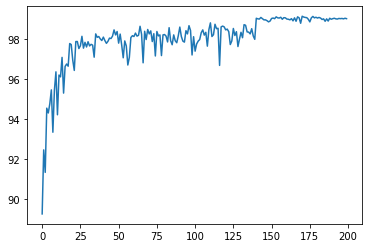

In [14]:
plt.plot(test_accs)

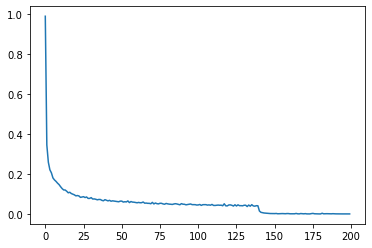

In [15]:
plt.plot(train_losses)

In [1]:
test_accs

NameError: name 'test_accs' is not defined